# Maritime Trade: MLP
## Train 2010 - 2019

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
# Install and import packages
!pip install --upgrade pip
!pip install category_encoders
!pip install tensorflow
!pip install keras-tuner
import os
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import keras_tuner
from keras_tuner import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
my_dpi = 96
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/96/82/0cf7cb3922f9eb408e400b134b82437fc2898286b26e8cdf7cd5218ec71b/category_encoders-2.6.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.3 MB/s eta 0:00:00
TensorFlow version: 2.12.0
Eager execution is: True
Keras version: 2.12.0
Num GPUs Available:  1


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Thu Aug  3 21:49:24 2023       
+---------------------------------------------------------

In [ ]:
# Reproducibility in TF and Pytorch
def init_seeds(seed=1019):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

init_seeds(seed=1019)

In [ ]:
%cd /datasets/trade

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] < 2020]
print('Number of rows and columns:', df.shape)

In [ ]:
# Prepare for partitioning data
X = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y = df['Metric_Tons']

del df

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=X.Year,
                                                    random_state=1019)

del X, y

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print('Dimensions for input to MLP:', X_train.shape[1])

In [ ]:
# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

## Hyperparameter Optimization

In [ ]:
%cd /notebooks/MaritimeTrade/Models/DL/MLP/Models

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

## HPO3sc Batch=64 Layers:4-10 Min20, Max70

In [ ]:
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 4, 10)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=40, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_1019_HPO3sc',
    project_name='MLP_1019_HPO3'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=64,
             callbacks=callbacks)

Trial 20 Complete [00h 09m 48s]
val_loss: 7.726570129394531

Best val_loss So Far: 7.574731826782227
Total elapsed time: 03h 16m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_1019_HPO5sc/MLP_1019_HPO5
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 40
learning_rate: 0.001
layer_size4: 70
layer_size5: 40
layer_size6: 40
layer_size7: 50
layer_size8: 40
layer_size9: 70
Score: 7.574731826782227
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 70
layer_size1: 70
layer_size2: 40
layer_size3: 40
learning_rate: 0.001
layer_size4: 40
layer_size5: 40
layer_size6: 40
layer_size7: 45
layer_size8: 40
layer_size9: 70
Score: 7.581704616546631
Trial summary
Hyperparameters:
num_layers: 9
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 50
learning_rate: 0.001
layer_size4: 40
layer_size5: 40
layer_size6: 40
layer_size7: 70
layer_size8: 40
layer_size9: 65
Score: 7.6131720542907715
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 40
learning_rate: 0.001
layer_size4: 40
layer_size5: 40
l

### Fit best model - Batch Size = 64

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1019_b64_sc_epochs30_HPO3batch64.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Add model
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 40)                2840      
                                                                 
 dense_4 (Dense)             (None, 70)                2870      
                                                                 
 dense_5 (Dense)             (None, 40)                2840      
                                                                 
 dense_6 (Dense)             (None, 40)                1

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

2022-12-09 14:00:55.397874: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3675970384 exceeds 10% of free system memory.
2022-12-09 14:00:58.561630: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3675970384 exceeds 10% of free system memory.
2022-12-09 14:01:01.213970: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3675970384 exceeds 10% of free system memory.


Epoch 1/30
211166/211166 [==============================] - 615s 3ms/step - loss: 8.2495 - mse: 362.4219 - val_loss: 7.6832 - val_mse: 328.4673
Epoch 2/30
211166/211166 [==============================] - 606s 3ms/step - loss: 7.7062 - mse: 323.1420 - val_loss: 7.3662 - val_mse: 308.9804
Epoch 3/30
211166/211166 [==============================] - 607s 3ms/step - loss: 7.5485 - mse: 312.0172 - val_loss: 7.2437 - val_mse: 301.7161
Epoch 4/30
211166/211166 [==============================] - 609s 3ms/step - loss: 7.4666 - mse: 305.3742 - val_loss: 7.1936 - val_mse: 295.8761
Epoch 5/30
211166/211166 [==============================] - 588s 3ms/step - loss: 7.4155 - mse: 301.9452 - val_loss: 7.1579 - val_mse: 298.1034
Epoch 6/30
211166/211166 [==============================] - 596s 3ms/step - loss: 7.3644 - mse: 299.3010 - val_loss: 7.1220 - val_mse: 299.1560
Epoch 7/30
211166/211166 [==============================] - 592s 3ms/step - loss: 7.3306 - mse: 297.2220 - val_loss: 7.1063 - val_mse: 2

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO3batch64_train1019_tf.h5',
           save_format='tf')

# Load model for more training or later use
#model = tf.keras.models.load_model('./MLP_batch64_sc_30Epochs_HPO3batch64_train1019_tf.h5')
#filepath = 'MLP_weights_only_train1019_b64_sc_epochs30_HPO3batch64.h5'
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

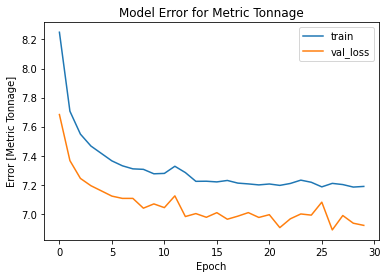

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1019_batch64_sc_30Epochs_HPO3batch64_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

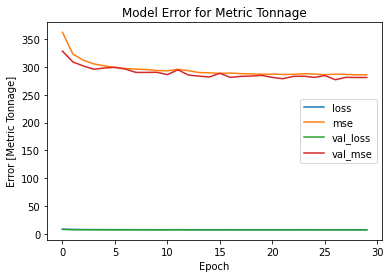

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1019_batch64_sc_30Epochs_HPO3batch64_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

2022-12-09 19:56:25.452537: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4594963184 exceeds 10% of free system memory.
2022-12-09 19:56:29.338619: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4594963184 exceeds 10% of free system memory.
2022-12-09 19:56:32.455179: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4594963184 exceeds 10% of free system memory.


527914/527914 [==============================] - 583s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(16893247, 1)

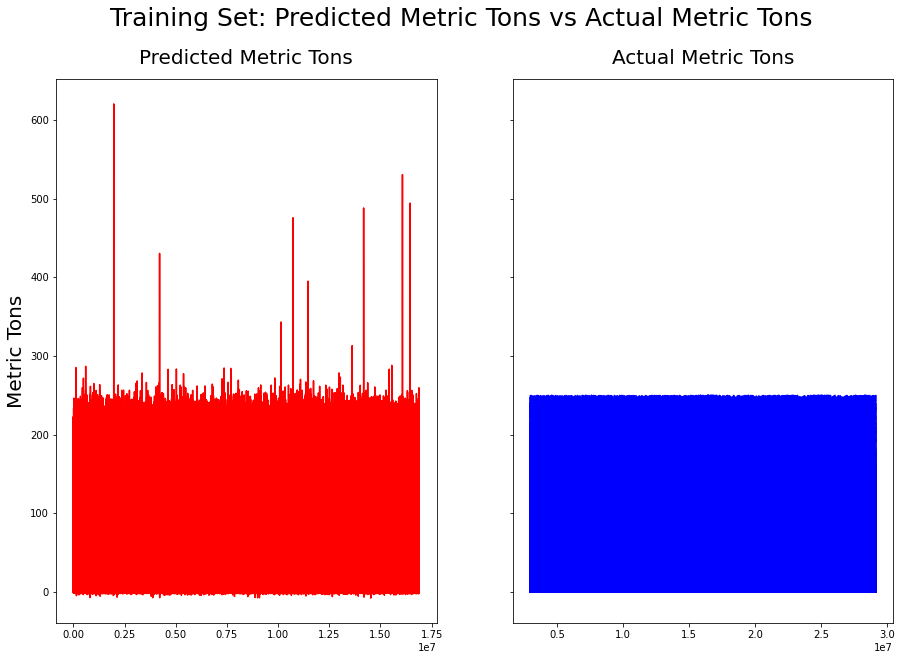

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1019_batch64_sc_30Epochs_HPO3batch64_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

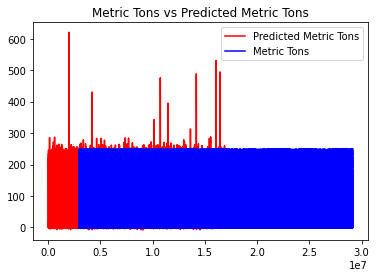

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1019_batch64_sc_30Epochs_HPO3batch64_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

226249/226249 [==============================] - 248s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(7239963, 1)

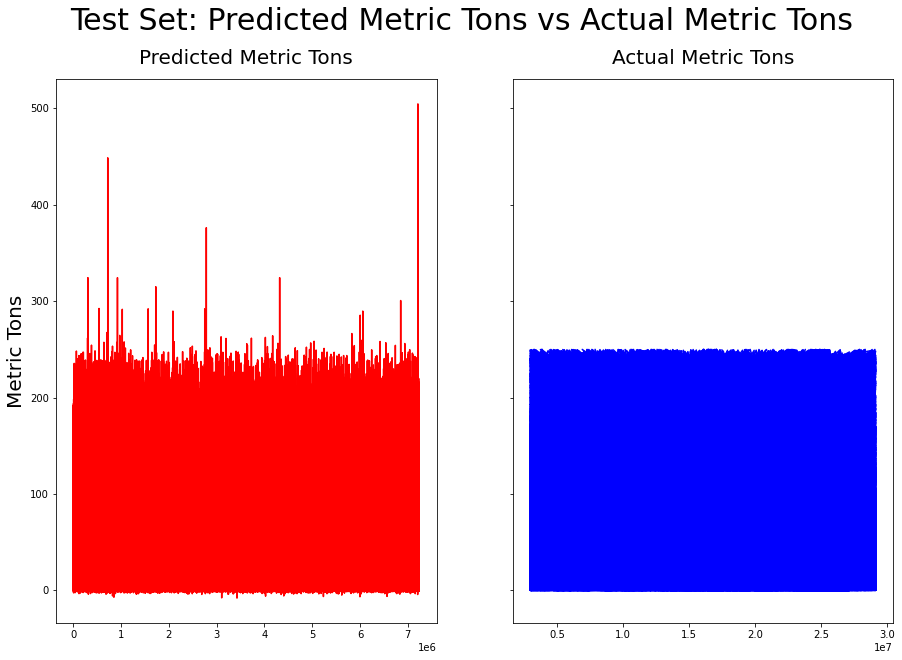

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1019_batch64_sc_30Epochs_HPO3batch64_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

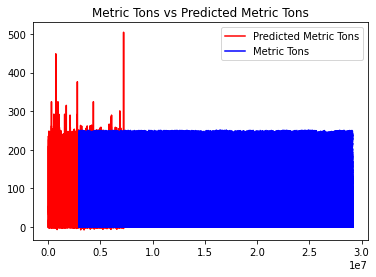

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1019_batch64_sc_30Epochs_HPO3batch64_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.894741
MSE: 278.528011
RMSE: 16.689158
R2: 0.607049


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.018941
MSE: 363.583865
RMSE: 19.067875
R2: 0.486804


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 504.63977

Average Metric Tons: 20.17341674121816
Predicted Average Metric Tons: 17.044321

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -8.115822


#### Test on 2020

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/datasets/trade


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] == 2020]

In [ ]:
# Prepare 2020 testing model
X = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y = df['Metric_Tons']

In [ ]:
# Process
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
%cd /notebooks/MaritimeTrade/Models/DL/MLP/Models

/notebooks/MaritimeTrade/Models/DL/MLP/Models


In [ ]:
# Predict on test set
pred_test = model.predict(X)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

93590/93590 [==============================] - 104s 1ms/step


(2994852, 1)

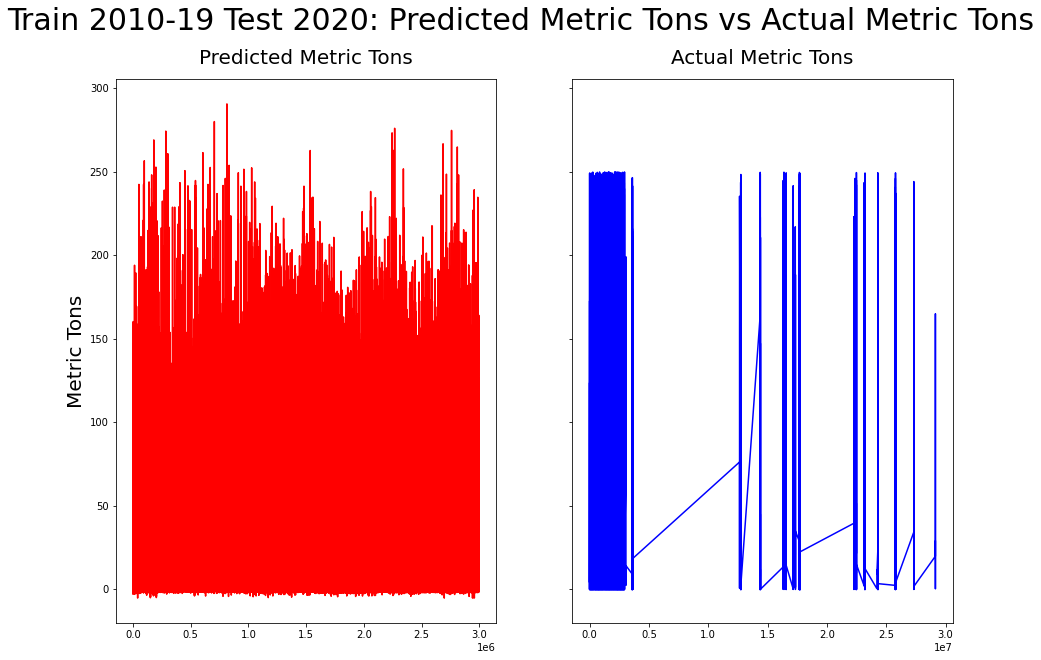

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2010-19 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train1019Test2020_batch64_sc_30Epochs_HPO3batch64_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

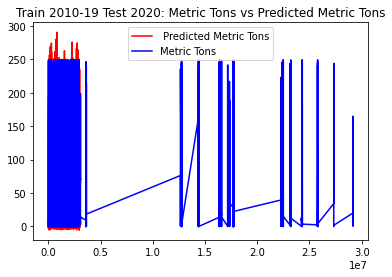

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2010-19 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1019Test2020_batch64_sc_30Epochs_HPO3batch64_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.437581
MSE: 447.262350
RMSE: 21.148578
R2: 0.279419


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 290.6948

Average Metric Tons: 19.548126725460893
Predicted Average Metric Tons: 13.086369

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -5.168238


## HPO5sc Batch Size=64 Layers: 7-13 Min40, Max70

In [ ]:
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 7, 13)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=40, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_1019_HPO5sc',
    project_name='MLP_1019_HPO5'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 7, 'max_value': 13, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size4 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size5 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size6 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (C

In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=64,
             callbacks=callbacks)

Trial 20 Complete [00h 15m 35s]
val_loss: 7.923251152038574

Best val_loss So Far: 7.6570143699646
Total elapsed time: 03h 52m 26s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_1019_HPO5sc/MLP_1019_HPO5
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 13
layer_size0: 70
layer_size1: 65
layer_size2: 70
layer_size3: 45
layer_size4: 40
layer_size5: 65
layer_size6: 55
learning_rate: 0.001
layer_size7: 65
layer_size8: 70
layer_size9: 70
layer_size10: 45
layer_size11: 60
layer_size12: 45
Score: 7.6570143699646
Trial summary
Hyperparameters:
num_layers: 13
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 70
layer_size4: 70
layer_size5: 70
layer_size6: 40
learning_rate: 0.0001
layer_size7: 50
layer_size8: 40
layer_size9: 40
layer_size10: 40
layer_size11: 70
layer_size12: 70
Score: 7.803870677947998
Trial summary
Hyperparameters:
num_layers: 13
layer_size0: 70
layer_size1: 70
layer_size2: 65
layer_size3: 40
layer_size4: 55
layer_size5: 55
layer_size6: 45
learning_rate: 0.0001
layer_size7: 50
layer_size8: 70
layer_size9: 70
layer_size10: 40
layer_size11: 40
layer_size12: 40
Score: 7.825712203979492
Trial summa

### Fit best model - Batch Size = 64

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1019_b64_sc_epochs30_HPO5batch64.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Add model
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(65, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(45, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(65, kernel_initializer='normal', activation='relu'))
model.add(Dense(55, kernel_initializer='normal', activation='relu'))

model.add(Dense(65, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(45, kernel_initializer='normal', activation='relu'))
model.add(Dense(60, kernel_initializer='normal', activation='relu'))
model.add(Dense(45, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 65)                4615      
                                                                 
 dense_2 (Dense)             (None, 70)                4620      
                                                                 
 dense_3 (Dense)             (None, 45)                3195      
                                                                 
 dense_4 (Dense)             (None, 40)                1840      
                                                                 
 dense_5 (Dense)             (None, 65)                2665      
                                                                 
 dense_6 (Dense)             (None, 55)                3

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
211166/211166 [==============================] - 799s 4ms/step - loss: 8.4668 - mse: 370.8006 - val_loss: 7.6819 - val_mse: 326.4359
Epoch 2/30
211166/211166 [==============================] - 790s 4ms/step - loss: 7.9550 - mse: 335.6031 - val_loss: 7.4567 - val_mse: 313.6351
Epoch 3/30
211166/211166 [==============================] - 786s 4ms/step - loss: 7.8063 - mse: 323.3239 - val_loss: 7.3470 - val_mse: 305.1347
Epoch 4/30
211166/211166 [==============================] - 786s 4ms/step - loss: 7.7147 - mse: 316.8416 - val_loss: 7.2930 - val_mse: 299.3869
Epoch 5/30
211166/211166 [==============================] - 786s 4ms/step - loss: 7.6586 - mse: 312.8250 - val_loss: 7.2685 - val_mse: 300.4239
Epoch 6/30
211166/211166 [==============================] - 788s 4ms/step - loss: 7.5796 - mse: 308.3514 - val_loss: 7.1673 - val_mse: 294.8160
Epoch 7/30
211166/211166 [==============================] - 785s 4ms/step - loss: 7.5308 - mse: 305.4005 - val_loss: 7.1690 - val_mse: 2

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO5batch64_train1019_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train1019_b64_sc_epochs30_HPO5batch64.h5'
#model = tf.keras.models.load_model('./MLP_batch64_sc_30Epochs_HPO5batch64_train1019_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

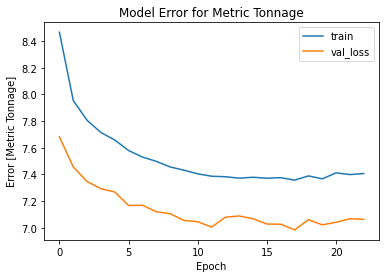

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1019_batch64_sc_30Epochs_HPO5batch64_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

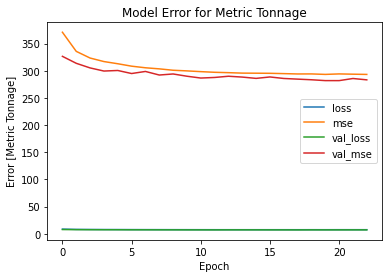

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1019_batch64_sc_30Epochs_HPO5batch64_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

527914/527914 [==============================] - 812s 2ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(16893247, 1)

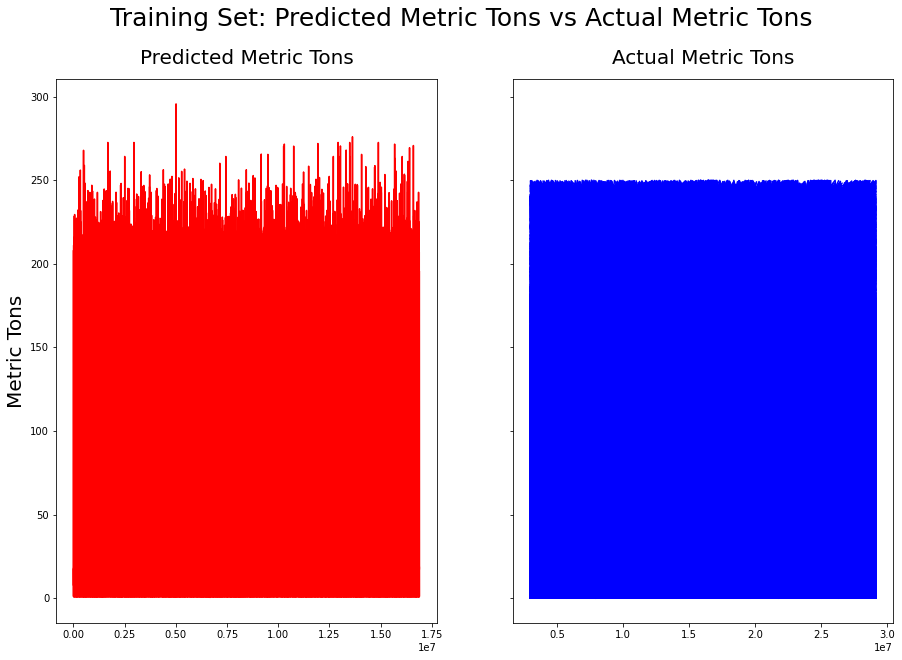

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1019_batch64_sc_30Epochs_HPO5batch64_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

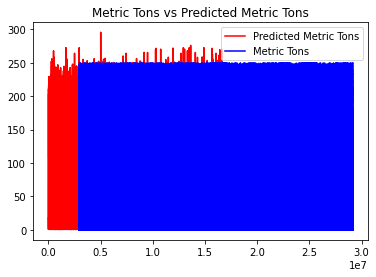

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1019_batch64_sc_30Epochs_HPO5batch64_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

226249/226249 [==============================] - 350s 2ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(7239963, 1)

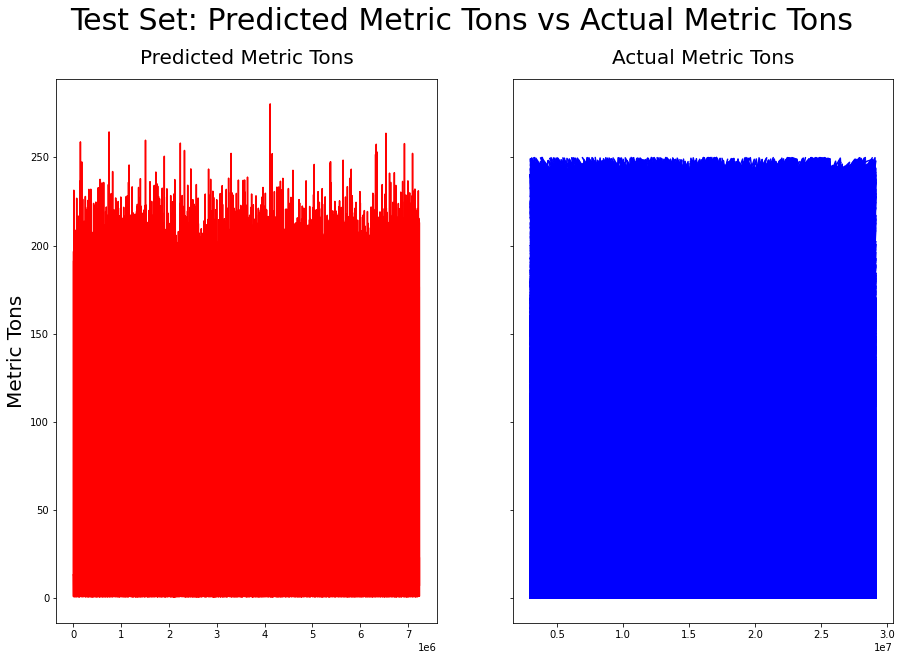

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1019_batch64_sc_30Epochs_HPO5batch64_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

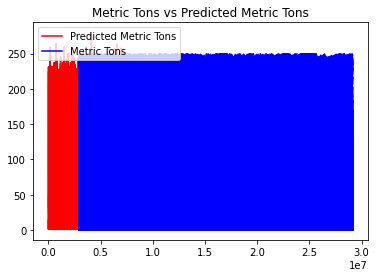

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1019_batch64_sc_30Epochs_HPO5batch64_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 7.040382
MSE: 280.990830
RMSE: 16.762781
R2: 0.603574


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.052270
MSE: 359.919602
RMSE: 18.971547
R2: 0.491976


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 280.35706

Average Metric Tons: 20.17341674121816
Predicted Average Metric Tons: 16.623627

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: 0.54962707


#### Test on 2020

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data

/datasets/trade


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] == 2020]

In [ ]:
# Prepare 2020 testing model
X = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y = df['Metric_Tons']

In [ ]:
# Process
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

93590/93590 [==============================] - 127s 1ms/step


(2994852, 1)

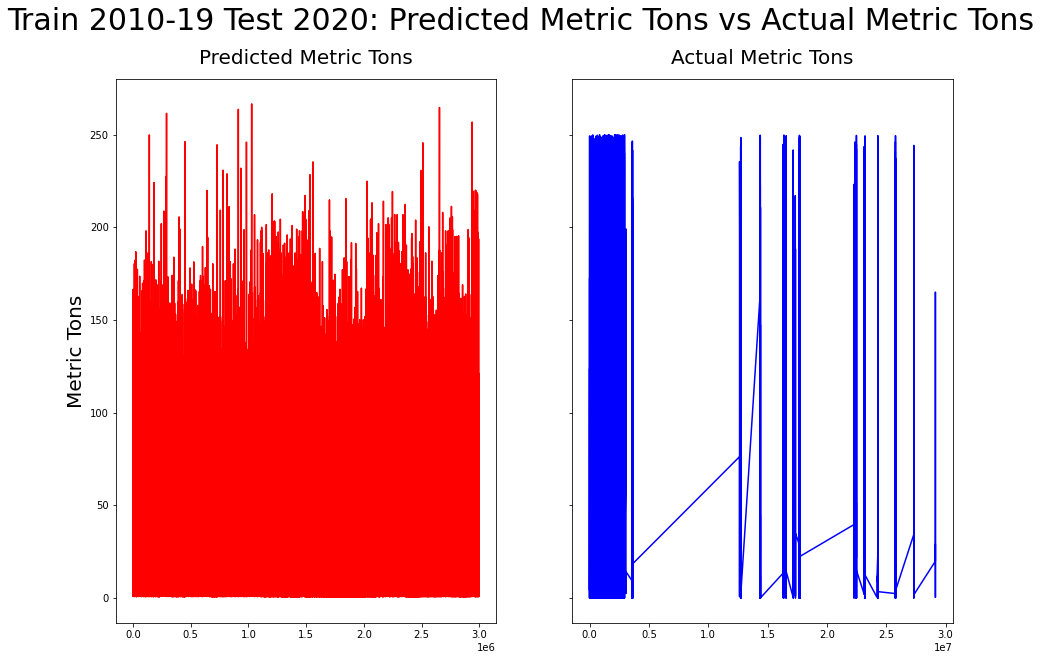

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Train 2010-19 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1019Test20_baselineSC_batch32_30Epochs_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

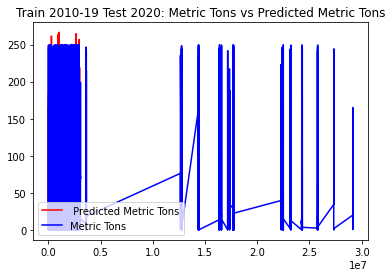

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Train 2010-19 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.734576
MSE: 448.732405
RMSE: 21.183305
R2: 0.277051


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 266.59167

Average Metric Tons: 19.548126725460893
Predicted Average Metric Tons: 12.666425

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: 0.46689343
